#### Using GoogLeNet as Classify Model
Following GoogLeNet implementation from this [blog](https://ai.plainenglish.io/googlenet-inceptionv1-with-tensorflow-9e7f3a161e87)

Use GoogLeNet to classify defect patterns only (i.e., as an alternative to Yu classify model).  Data resized to 224x224 and not filtered.

In [1]:
# !pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, callbacks, Model

import os
import time
import numpy as np
import pandas as pd

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# specify variables for model
path = 'processed_data/WM-clean224'
result_path = 'results'
model_path = '../saved_models'

filename = 'WM-clean224'
option = '-classify' # -classify, -knn
map_column = 'waferMap224'

model_id = 'googlenet'
data_id = '224'
note = '' # -optional

x = 224
y = 224

In [6]:
# load train, dev, and test sets
# directly from S3 (using boto3 resource)
start = time.time()

train_key = f'{path}/{filename}-train{option}.pkl'
dev_key = f'{path}/{filename}-dev.pkl'
test_key = f'{path}/{filename}-test.pkl'

train = pickle.loads(my_bucket.Object(train_key).get()['Body'].read())
dev = pickle.loads(my_bucket.Object(dev_key).get()['Body'].read())
test = pickle.loads(my_bucket.Object(test_key).get()['Body'].read())

# remove nones from dev and test

dev = dev[dev.classifyLabels != 8].reset_index(drop=True)
test = test[test.classifyLabels != 8].reset_index(drop=True)

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

print(f"Sanity check: {np.unique(train[map_column][0])}")

Wall time: 42.29 seconds
Train: 17863
Dev: 3828
Test: 3828
Sanity check: [0 1 2]


#### Quick EDA

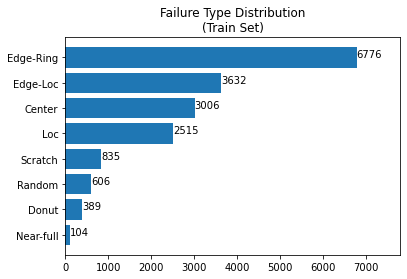

In [7]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

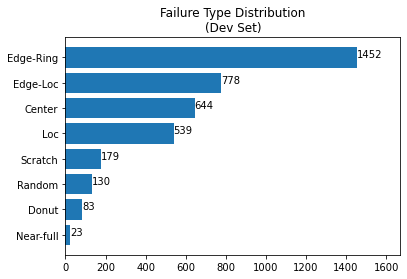

In [8]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

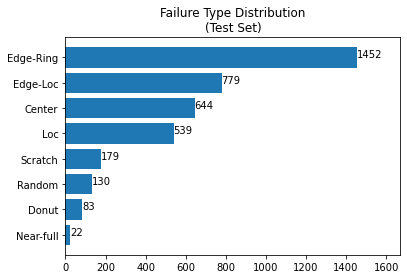

In [9]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [10]:
# prepare inputs
start = time.time()

x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: (#rows, xdim, ydim)
print(x_train.shape)

Wall time: 0.41 seconds
(17863, 224, 224)


In [11]:
# expand tensor and repeat 3 times
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

x_train = tf.repeat(x_train, 3, axis=3)
x_val = tf.repeat(x_val, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 3])
x_train.shape

Wall time: 4.49 seconds


TensorShape([17863, 224, 224, 3])

In [12]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = np.asarray(train['classifyLabels']).astype(np.uint8)
y_val = np.asarray(dev['classifyLabels']).astype(np.uint8)
y_test = np.asarray(test['classifyLabels']).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 7
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.00 seconds
<class 'numpy.uint8'>
0 0 0
7 7 7


#### Model

In [13]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [14]:
inp = layers.Input(shape=(x, y, 3))
input_tensor = layers.experimental.preprocessing.Rescaling(scale=1./2.)(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(9, activation='softmax')(x)

In [15]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [16]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [17]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=30)

Epoch 1/30
280/280 [==============================] - 45s 162ms/step - loss: 1.9580 - dense_4_loss: 1.2257 - dense_1_loss: 1.2203 - dense_3_loss: 1.2208 - dense_4_accuracy: 0.5197 - dense_1_accuracy: 0.5340 - dense_3_accuracy: 0.5331 - val_loss: 1.4363 - val_dense_4_loss: 0.9155 - val_dense_1_loss: 0.8814 - val_dense_3_loss: 0.8545 - val_dense_4_accuracy: 0.6403 - val_dense_1_accuracy: 0.6426 - val_dense_3_accuracy: 0.6698
Epoch 2/30
280/280 [==============================] - 43s 155ms/step - loss: 1.1695 - dense_4_loss: 0.7191 - dense_1_loss: 0.7697 - dense_3_loss: 0.7318 - dense_4_accuracy: 0.7312 - dense_1_accuracy: 0.7034 - dense_3_accuracy: 0.7237 - val_loss: 0.9559 - val_dense_4_loss: 0.5969 - val_dense_1_loss: 0.6222 - val_dense_3_loss: 0.5748 - val_dense_4_accuracy: 0.7751 - val_dense_1_accuracy: 0.7612 - val_dense_3_accuracy: 0.7816
Epoch 3/30
280/280 [==============================] - 43s 154ms/step - loss: 0.8630 - dense_4_loss: 0.5197 - dense_1_loss: 0.6036 - dense_3_loss: 

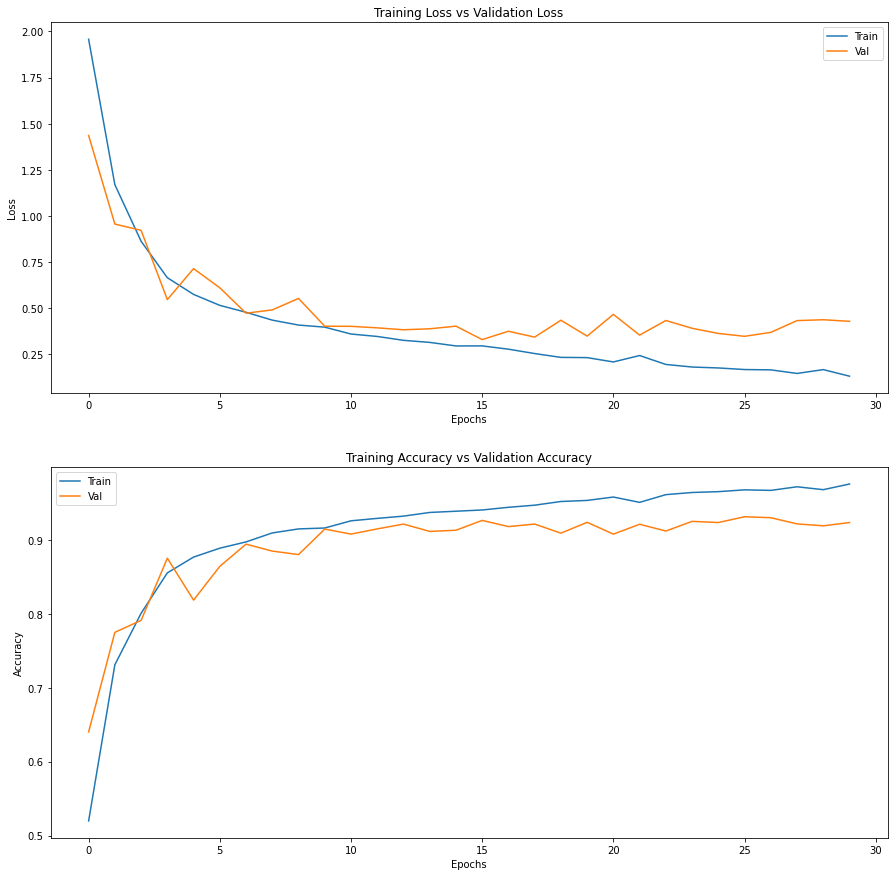

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [19]:
# save model to S3
s3_save_keras_model(model, f'{model_id}-{data_id}{note}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpidxlvofx/googlenet-224/assets


In [20]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

120/120 [==============================] - 3s 27ms/step - loss: 0.3783 - dense_4_loss: 0.2305 - dense_1_loss: 0.2484 - dense_3_loss: 0.2445 - dense_4_accuracy: 0.9305 - dense_1_accuracy: 0.9237 - dense_3_accuracy: 0.9279
Wall time: 4.78 seconds
[0.378327876329422, 0.2304699420928955, 0.24839194118976593, 0.24446770548820496, 0.930512011051178, 0.9237199425697327, 0.9278996586799622]


In [21]:
# generate predictions for model analysis
start = time.time()
pred = model.predict(x_test)
y_pred = np.argmax(pred[0], axis=1)
predictions = [y_pred, pred]
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 3.185560941696167 seconds


In [22]:
# save predictions
# save to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

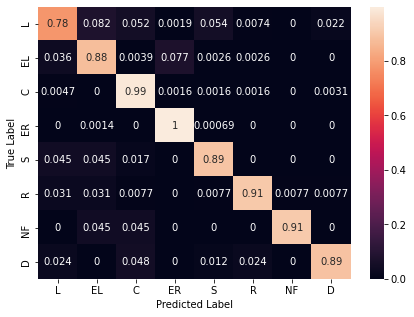

In [23]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_pred, mode='classify', normalize=True)

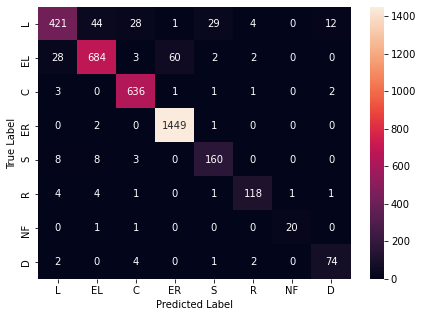

In [24]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_pred, mode='classify', normalize=False)